In [15]:
import random
import torch
import numpy as np
from model.resnet import ResNet18
from model.smooth_cross_entropy import smooth_crossentropy
from data.cifar import Cifar
from utility.log import Log
from utility.step_lr import StepLR
from utility.bypass_bn import enable_running_stats, disable_running_stats
import matplotlib.pyplot as plt

import sys; sys.path.append("..")
from sam import SAM

In [2]:
adaptive =  True
batch_size = 128
depth = 16
dropout = 0.0
epochs = 200
label_smoothing = 0.1
learning_rate = 0.001
momentum= 0.9
threads = 5
rho = 2.0
weight_decay = 0.0005
width_factor = 8

In [3]:
def initialize(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

In [4]:
initialize(seed=42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
dataset = Cifar(batch_size, threads)
log = Log(log_each=10)
model = ResNet18(num_classes=10).to(device)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
base_optimizer = torch.optim.Adam
optimizer = SAM(model.parameters(), base_optimizer, rho=rho, adaptive=adaptive, lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, learning_rate, epochs)

In [7]:
train_losses = np.zeros(epochs)
train_accuracy = np.zeros(epochs)
val_losses = np.zeros(epochs)
val_accuracy = np.zeros(epochs)

In [8]:
for epoch in range(epochs):
    model.train()
    log.train(len_dataset=len(dataset.train))

    for batch in dataset.train:
        inputs, targets = (b.to(device) for b in batch)

        # first forward-backward step
        enable_running_stats(model)
        predictions = model(inputs)
        loss = smooth_crossentropy(predictions, targets, smoothing=label_smoothing)
        loss.mean().backward()
        optimizer.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(model)
        smooth_crossentropy(model(inputs), targets, smoothing=label_smoothing).mean().backward()
        optimizer.second_step(zero_grad=True)

        with torch.no_grad():
            correct = torch.argmax(predictions.data, 1) == targets
            log(model, loss.cpu(), correct.cpu(), scheduler.lr())
            scheduler(epoch)

    model.eval()
    cur_loss, cur_acc = log.eval(len_dataset=len(dataset.test))
    train_losses[epoch] = cur_loss
    train_accuracy[epoch] = cur_acc

    with torch.no_grad():
        for batch in dataset.test:
            inputs, targets = (b.to(device) for b in batch)

            predictions = model(inputs)
            loss = smooth_crossentropy(predictions, targets)
            correct = torch.argmax(predictions, 1) == targets
            log(model, loss.cpu(), correct.cpu())
        if epoch > 0:
            val_losses[epoch-1] = log.current_valid_loss
            val_accuracy[epoch-1] = log.current_valid_accuracy

val_losses[epochs-1] = log.current_valid_loss
val_accuracy[epochs-1] = log.current_valid_accuracy
log.flush()

┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃
┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨
┃           0  ┃      1.2028  │     42.40 %  ┃   1.000e-03  │   04:40 min  ┃┈██████████████████████████▓┈┨      1.0204  │     52.66 %  ┃
┃           1  ┃      0.8172  │     62.40 %  ┃   1.000e-03  │   06:57 min  ┃┈██████████████████████████▓┈┨      0.9666  │     56.39 %  ┃
┃           2  ┃      0.6656  │     70.19 %  ┃   1.000e-03  │   07:27 min  ┃┈██████████████████████████▓┈┨      0.6946  │     67.94 %  ┃
┃           3  ┃      0.5682  │     75.10 %  ┃   1.000e-03  │   08:03 min  ┃┈██████████████████████████▓┈┨      0.6878  │     69.11 %  ┃
┃           4  ┃      0.

┃          56  ┃      0.2158  │     91.63 %  ┃   1.000e-03  │   05:35 min  ┃┈██████████████████████████▓┈┨      0.2663  │     88.24 %  ┃
┃          57  ┃      0.2142  │     91.67 %  ┃   1.000e-03  │   05:29 min  ┃┈██████████████████████████▓┈┨      0.2498  │     89.56 %  ┃
┃          58  ┃      0.2149  │     91.61 %  ┃   1.000e-03  │   06:09 min  ┃┈██████████████████████████▓┈┨      0.3253  │     85.93 %  ┃
┃          59  ┃      0.2146  │     91.61 %  ┃   1.000e-03  │   05:20 min  ┃┈██████████████████████████▓┈┨      0.2443  │     89.70 %  ┃
┃          60  ┃      0.1564  │     94.12 %  ┃   2.000e-04  │   05:06 min  ┃┈██████████████████████████▓┈┨      0.1713  │     92.73 %  ┃
┃          61  ┃      0.1366  │     95.07 %  ┃   2.000e-04  │   05:06 min  ┃┈██████████████████████████▓┈┨      0.1641  │     93.01 %  ┃
┃          62  ┃      0.1276  │     95.51 %  ┃   2.000e-04  │   05:31 min  ┃┈██████████████████████████▓┈┨      0.1605  │     93.18 %  ┃
┃          63  ┃      0.1224  │     95.76

┃         116  ┃      0.0664  │     98.15 %  ┃   2.000e-04  │   14:24 min  ┃┈██████████████████████████▓┈┨      0.1528  │     93.38 %  ┃
┃         117  ┃      0.0649  │     98.17 %  ┃   2.000e-04  │   14:29 min  ┃┈██████████████████████████▓┈┨      0.1458  │     93.68 %  ┃
┃         118  ┃      0.0657  │     98.21 %  ┃   2.000e-04  │   14:41 min  ┃┈██████████████████████████▓┈┨      0.1422  │     93.83 %  ┃
┃         119  ┃      0.0653  │     98.24 %  ┃   2.000e-04  │   14:47 min  ┃┈██████████████████████████▓┈┨      0.1442  │     93.65 %  ┃
┃         120  ┃      0.0507  │     98.71 %  ┃   4.000e-05  │   14:37 min  ┃┈██████████████████████████▓┈┨      0.1239  │     94.42 %  ┃
┃         121  ┃      0.0444  │     98.89 %  ┃   4.000e-05  │   13:40 min  ┃┈██████████████████████████▓┈┨      0.1202  │     94.72 %  ┃
┃         122  ┃      0.0422  │     98.93 %  ┃   4.000e-05  │   09:44 min  ┃┈██████████████████████████▓┈┨      0.1195  │     94.93 %  ┃
┃         123  ┃      0.0404  │     98.97

┃         176  ┃      0.0202  │     99.44 %  ┃   8.000e-06  │   07:15 min  ┃┈██████████████████████████▓┈┨      0.1145  │     95.01 %  ┃
┃         177  ┃      0.0205  │     99.44 %  ┃   8.000e-06  │   07:15 min  ┃┈██████████████████████████▓┈┨      0.1144  │     94.94 %  ┃
┃         178  ┃      0.0200  │     99.45 %  ┃   8.000e-06  │   07:22 min  ┃┈██████████████████████████▓┈┨      0.1139  │     95.05 %  ┃
┃         179  ┃      0.0203  │     99.46 %  ┃   8.000e-06  │   07:22 min  ┃┈██████████████████████████▓┈┨      0.1149  │     94.97 %  ┃
┃         180  ┃      0.0202  │     99.45 %  ┃   8.000e-06  │   07:25 min  ┃┈██████████████████████████▓┈┨      0.1147  │     94.87 %  ┃
┃         181  ┃      0.0194  │     99.46 %  ┃   8.000e-06  │   07:25 min  ┃┈██████████████████████████▓┈┨      0.1138  │     94.96 %  ┃
┃         182  ┃      0.0200  │     99.46 %  ┃   8.000e-06  │   07:32 min  ┃┈██████████████████████████▓┈┨      0.1142  │     94.93 %  ┃
┃         183  ┃      0.0198  │     99.47

In [10]:
torch.save(model.state_dict(), 'model_adam_resnet.ckpt')

In [12]:
val_losses[epochs-1] = log.current_valid_loss
val_accuracy[epochs-1] = log.current_valid_accuracy

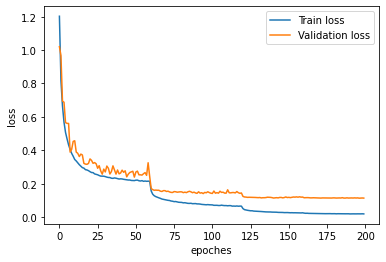

In [16]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()

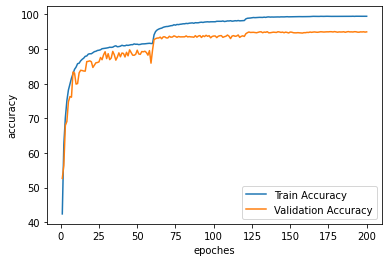

In [17]:
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.legend()